<a href="https://colab.research.google.com/github/LeylaY1996/sentiment-analysis-aws-reviews/blob/main/18122024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import pandas as pd

# Veri setini yükle
csv_file_path = '/content/Reviews-2.csv'  # Dosya yolunuza göre güncelleyin
df = pd.read_csv(csv_file_path, on_bad_lines='skip', quoting=3, low_memory=False)  # daha yeni versiyonlar için
# Veri setinin boyutunu yazdır
print("Orijinal veri seti boyutu:", df.shape)

# %50 oranında rastgele bir alt küme seç
sampled_df = df.sample(frac=0.5, random_state=42)  # random_state ile tekrarlanabilirlik sağlar

# Yeni veri setinin boyutunu yazdır
print("Yeni veri seti boyutu:", sampled_df.shape)

# İstediğiniz gibi veriyi kaydedin veya kullanın
sampled_df.to_csv('sampled_reviews.csv', index=False)  # Yeni dosyayı kaydet

Orijinal veri seti boyutu: (88824, 10)
Yeni veri seti boyutu: (44412, 10)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


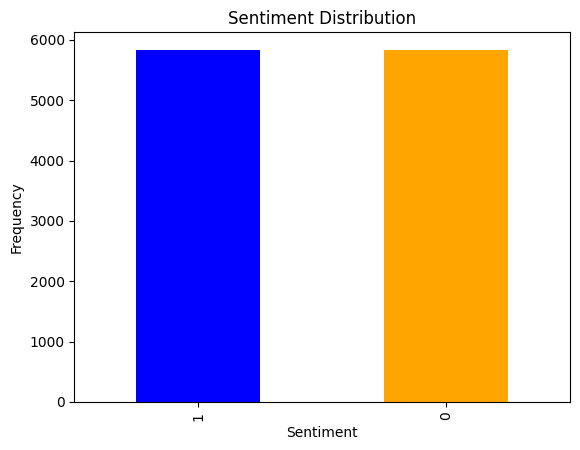

Ortalama Yorum Uzunluğu: 139.1858611825193
Standart Sapma: 88.3874931615899
                                          cleaned_review  Sentiment  \
37613  used liked taken time bake summer use winter t...          1   
42131  tea awesome keep stirring sits long taste grea...          1   
19168  dog buddy phickel comes dog food one day loves...          1   
29585  dog finiky especially comes taking supplements...          1   
9222   ive got granddaughter picky eats one foods eat...          1   
...                                                  ...        ...   
28624  dont buy threw garbage trying thosebr dont kno...          0   
39511  tea tastes average smells great dont like heav...          0   
39782  basically potatoes cream youre lucky may get 3...          0   
41242  drinking costa rican coffee years came bag bla...          0   
6845   frito lays sell 2 1 says picture confirmed loc...          0   

        ProductId          UserId  
37613  B0020ZURDI   AA8EVHLG6J5N3  

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import string
from scipy import stats

# NLTK stopwords yükle
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
punctuation = string.punctuation

def clean_text(text):
    """Metni temizler: küçük harfe çevirir, noktalama işaretlerini kaldırır ve durak kelimeleri filtreler."""
    text = text.lower()  # Küçük harfe çevir
    text = ''.join([char for char in text if char not in punctuation])  # Noktalama işaretlerini kaldır
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Durak kelimeleri filtrele
    return text

def prepare_data(csv_file):
    """Veri setini hazırlar: yükler, temizler ve etiketler."""

    # Veri setini yükle
    df = pd.read_csv(csv_file)

    # Gerekli sütunları seçin
    df = df[['Text', 'Score', 'ProductId', 'UserId']]

    # 3 değerine sahip satırları çıkarın
    df = df[df['Score'] != 3]

    # Skorları ikili hale getirin (örneğin: 1-2 olumsuz, 4-5 olumlu)
    df['Sentiment'] = df['Score'].apply(lambda x: 1 if x >= 4 else 0)

    # Yorumları temizle
    df['cleaned_review'] = df['Text'].apply(clean_text)

    # Sadece temizlenmiş yorumlar ve duygu etiketlerini içeren DataFrame döndür
    return df[['cleaned_review', 'Sentiment', 'ProductId', 'UserId']]

# Veriyi yükle ve hazırla
csv_file_path = '/content/sampled_reviews.csv'  # Dosya yolunuza göre güncelleyin
prepared_data = prepare_data(csv_file_path)

# Veri dengesini sağlama
# Olumlu ve olumsuz örneklerin sayısını bul
positive_samples = prepared_data[prepared_data['Sentiment'] == 1]
negative_samples = prepared_data[prepared_data['Sentiment'] == 0]

# Minimum sayıda olan sınıfa göre dengeleme
min_samples = min(len(positive_samples), len(negative_samples))
balanced_data = pd.concat([positive_samples.sample(min_samples, random_state=42),
                           negative_samples.sample(min_samples, random_state=42)])

# Histogram çizme
balanced_data['Sentiment'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.show()

# Ortalama ve standart sapma hesaplama
mean_length = balanced_data['cleaned_review'].apply(len).mean()
std_length = balanced_data['cleaned_review'].apply(len).std()
print(f"Ortalama Yorum Uzunluğu: {mean_length}")
print(f"Standart Sapma: {std_length}")

# Aykırı değer kontrolü (örneğin, yorum uzunluğuna göre aykırı değer)
z_scores = np.abs(stats.zscore(balanced_data['cleaned_review'].apply(len)))
balanced_data = balanced_data[(z_scores < 3)]
print(balanced_data)
print("Aykırı değerler çıkarıldıktan sonra veri seti boyutu:", balanced_data.shape)

In [30]:
# Confusion Matrix'i görselleştir
def plot_confusion_matrix(cm):
    """Confusion matrix'i görselleştirir."""
    fig, ax = plt.subplots(figsize=(6,6))
    ax.matshow(cm, cmap='Blues', alpha=0.6)
    for (i, j), val in np.ndenumerate(cm):
        ax.text(j, i, f'{val}', ha='center', va='center', color='red')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

def vectorize_text(train_text, test_text, max_features=10000, ngram_range=(1, 2)):
    """
    Metinleri TF-IDF ile vektörize eder.
    """
    vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range)
    X_train_tfidf = vectorizer.fit_transform(train_text)
    X_test_tfidf = vectorizer.transform(test_text)
    return X_train_tfidf, X_test_tfidf, vectorizer

In [32]:
from sklearn.model_selection import train_test_split

def split_data(df, feature_column, target_column, test_size=0.2, random_state=42):
    """
    Veri çerçevesini eğitim ve test setine böler.

    Args:
    - df: Veri çerçevesi (pandas DataFrame).
    - feature_column: Özellik sütunu adı (ör. metin verisi).
    - target_column: Hedef sütunu adı (etiketler).
    - test_size: Test setinin boyutu (varsayılan: 0.2).
    - random_state: Rastgele durum kontrolü için tohum (varsayılan: 42).

    Returns:
    - X_train: Eğitim seti özellikleri.
    - X_test: Test seti özellikleri.
    - y_train: Eğitim seti etiketleri.
    - y_test: Test seti etiketleri.
    """
    X_train, X_test, y_train, y_test = train_test_split(
        df[feature_column],
        df[target_column],
        test_size=test_size,
        random_state=random_state,
        stratify=df[target_column]  # Sınıf dengesini korumak için stratify
    )
    return X_train, X_test, y_train, y_test

In [33]:
from imblearn.over_sampling import SMOTE

def apply_smote(X, y, random_state=42):
    """
    SMOTE ile azınlık sınıfını artırır.
    """
    smote = SMOTE(random_state=random_state)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    return X_resampled, y_resampled

In [34]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    """
    Modeli eğitir ve değerlendirme metriklerini döner.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    return accuracy, report, cm

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


SVM with SMOTE Accuracy (Balanced Data): 0.903056768558952
SVM with SMOTE Classification Report (Balanced Data):
               precision    recall  f1-score   support

           0       0.90      0.90      0.90      1140
           1       0.90      0.90      0.90      1150

    accuracy                           0.90      2290
   macro avg       0.90      0.90      0.90      2290
weighted avg       0.90      0.90      0.90      2290

SVM with SMOTE Confusion Matrix (Balanced Data):
 [[1028  112]
 [ 110 1040]]


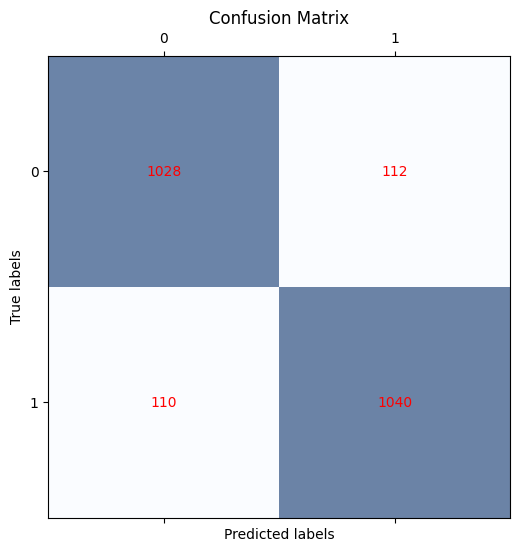

In [35]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

def svm_with_smote_sentiment_analysis_balanced(df):
    """Balanced veri seti ile SVM ve SMOTE kullanarak duygu analizi yapar."""

    # Eğitim ve test setine ayırma
    X_train, X_test, y_train, y_test = split_data(df, 'cleaned_review', 'Sentiment')

    # TF-IDF vektörleştirme
    X_train_tfidf, X_test_tfidf, _ = vectorize_text(X_train, X_test)

    # SMOTE ile veri dengeleme
    X_train_resampled, y_train_resampled = apply_smote(X_train_tfidf, y_train)

    # SVM modeli oluştur ve değerlendir
    model = SVC(kernel='linear', class_weight='balanced', random_state=42)
    accuracy, report, cm = train_and_evaluate_model(
        model, X_train_resampled, y_train_resampled, X_test_tfidf, y_test
    )

    return accuracy, report, cm

# SVM analizi
accuracy, report, cm = svm_with_smote_sentiment_analysis_balanced(balanced_data)

# Sonuçları yazdır
print("SVM with SMOTE Accuracy (Balanced Data):", accuracy)
print("SVM with SMOTE Classification Report (Balanced Data):\n", report)
print("SVM with SMOTE Confusion Matrix (Balanced Data):\n", cm)

plot_confusion_matrix(cm)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Naive Bayes with SMOTE Accuracy: 0.894759825327511
Naive Bayes with SMOTE Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.87      0.89      1140
           1       0.88      0.92      0.90      1150

    accuracy                           0.89      2290
   macro avg       0.90      0.89      0.89      2290
weighted avg       0.90      0.89      0.89      2290

Naive Bayes with SMOTE Confusion Matrix:
 [[ 992  148]
 [  93 1057]]


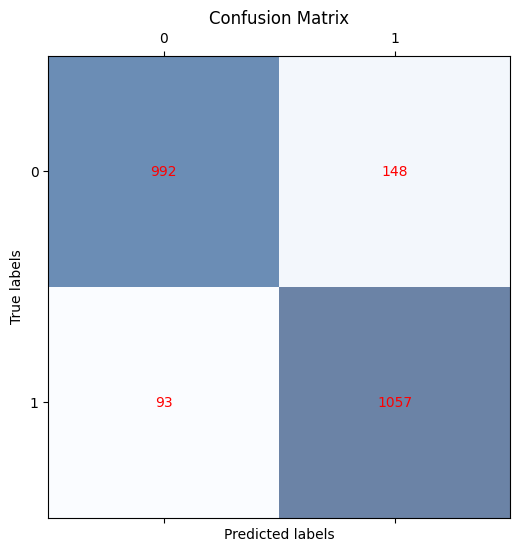

In [37]:
from sklearn.naive_bayes import MultinomialNB

def naive_bayes_with_smote_sentiment_analysis(df):
    """Naive Bayes ve SMOTE kullanarak duygu analizi yapar."""

    # Eğitim ve test setine ayırma
    X_train, X_test, y_train, y_test = split_data(df, 'cleaned_review', 'Sentiment')

    # TF-IDF vektörleştirme
    X_train_tfidf, X_test_tfidf, _ = vectorize_text(X_train, X_test)

    # SMOTE ile veri dengeleme
    X_train_resampled, y_train_resampled = apply_smote(X_train_tfidf, y_train)

    # Naive Bayes modelini oluştur
    model = MultinomialNB()

    # Modeli eğit ve değerlendir
    accuracy, report, cm = train_and_evaluate_model(
        model, X_train_resampled, y_train_resampled, X_test_tfidf, y_test
    )

    return accuracy, report, cm

# Naive Bayes analizi
accuracy, report, cm = naive_bayes_with_smote_sentiment_analysis(balanced_data)

# Sonuçları yazdır
print("Naive Bayes with SMOTE Accuracy:", accuracy)
print("Naive Bayes with SMOTE Classification Report:\n", report)
print("Naive Bayes with SMOTE Confusion Matrix:\n", cm)

plot_confusion_matrix(cm)

In [38]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def preprocess_text_with_tokenizer(train_text, test_text, max_length=100):
    """
    Metinleri tokenize eder ve belirli bir uzunlukta padding uygular.
    """
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(train_text)

    # Sayısal verilere dönüştürme
    train_seq = tokenizer.texts_to_sequences(train_text)
    test_seq = tokenizer.texts_to_sequences(test_text)

    # Padding işlemi
    train_padded = pad_sequences(train_seq, maxlen=max_length, padding='post')
    test_padded = pad_sequences(test_seq, maxlen=max_length, padding='post')

    return train_padded, test_padded, tokenizer

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

def build_rnn_model(input_dim, max_length, embedding_dim=100):
    """
    RNN (Bidirectional LSTM) modeli oluşturur.
    """
    model = Sequential()
    model.add(Embedding(input_dim=input_dim, output_dim=embedding_dim, input_length=max_length))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(32)))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 76s 464ms/step - accuracy: 0.6236 - loss: 0.8103 - val_accuracy: 0.8729 - val_loss: 0.3037
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 63s 437ms/step - accuracy: 0.9295 - loss: 0.2578 - val_accuracy: 0.8751 - val_loss: 0.3383
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 62s 430ms/step - accuracy: 0.9733 - loss: 0.1271 - val_accuracy: 0.8825 - val_loss: 0.3235
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 85s 449ms/step - accuracy: 0.9875 - loss: 0.0685 - val_accuracy: 0.8834 - val_loss: 0.4341
Epoch 5/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 75s 400ms/step - accuracy: 0.9930 - loss: 0.0428 - val_accuracy: 0.8716 - val_loss: 0.5060
Epoch 6/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 59s 406ms/step - accuracy: 0.9930 - loss: 0.0335 - val_accuracy: 0.8838 - val_loss: 0.4969
Epoch 7/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 86s 441ms/step - accuracy: 0.9944 - loss: 0.0233 - val_accuracy: 0.8817 - val_loss: 0.5229
Epoch 8/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 61s 421ms/step - accuracy: 0.9968 - loss: 0

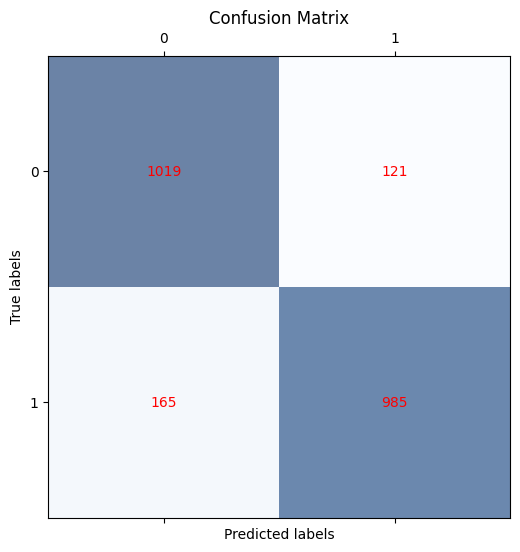

In [41]:
def rnn_with_balancing_smote(df):
    """RNN (Bidirectional LSTM) ve SMOTE kullanarak duygu analizi yapar."""

    # Eğitim ve test setine ayırma
    X_train, X_test, y_train, y_test = split_data(df, 'cleaned_review', 'Sentiment')

    # Metin ön işleme (tokenize ve padding)
    max_length = 100
    X_train_padded, X_test_padded, tokenizer = preprocess_text_with_tokenizer(X_train, X_test, max_length)

    # SMOTE ile veri dengeleme
    X_train_resampled, y_train_resampled = apply_smote(X_train_padded, y_train)

    # Model oluşturma
    input_dim = len(tokenizer.word_index) + 1  # Tokenizer'daki toplam kelime sayısı
    model = build_rnn_model(input_dim, max_length)

    # Modeli eğitme
    model.fit(
        X_train_resampled,
        y_train_resampled,
        epochs=10,
        batch_size=64,
        validation_data=(X_test_padded, y_test),
        class_weight={0: 2, 1: 1}  # Sınıf ağırlıkları
    )

    # Tahmin yap
    y_pred = (model.predict(X_test_padded) > 0.5).astype("int32").flatten()

    # Sonuçları değerlendir
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    return accuracy, report, cm

# Balanced data ile RNN analizi
accuracy, report, cm = rnn_with_balancing_smote(balanced_data)

# Sonuçları yazdır
print("SMOTE ile dengelenmiş RNN Accuracy:", accuracy)
print("SMOTE ile dengelenmiş RNN Classification Report:\n", report)
print("SMOTE ile dengelenmiş RNN Confusion Matrix:\n", cm)

plot_confusion_matrix(cm)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Lexicon-Based SMOTE Accuracy: 0.9372052401746724
Lexicon-Based SMOTE Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.92      0.94      5701
           1       0.92      0.95      0.94      5749

    accuracy                           0.94     11450
   macro avg       0.94      0.94      0.94     11450
weighted avg       0.94      0.94      0.94     11450

Lexicon-Based SMOTE Confusion Matrix:
 [[5257  444]
 [ 275 5474]]


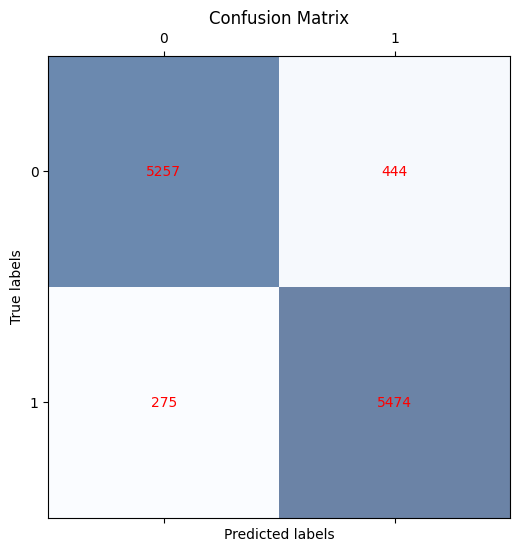

In [42]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

# Pozitif ve negatif kelimelerin listesi
positive_words = ['good', 'great', 'excellent', 'awesome', 'nice']
negative_words = ['bad', 'terrible', 'poor', 'worst', 'awful']

def lexicon_based_sentiment_analysis_with_smote_balanced(df):
    """Lexicon-based sentiment analizi SMOTE ile ve balanced_data kullanarak."""

    # Her yorumdaki kelimeleri analiz ederek duygu puanı döndür
    def get_sentiment(text):
        words = text.split()
        score = 0
        for word in words:
            if word in positive_words:
                score += 1
            elif word in negative_words:
                score -= 1
        return 1 if score > 0 else 0

    # Duygu etiketlerini tahmin et
    df['Lexicon_Sentiment'] = df['cleaned_review'].apply(get_sentiment)

    # Özellik ve etiketleri ayırma
    X = df['cleaned_review']  # Özellikler: Temizlenmiş yorumlar
    y = df['Sentiment']  # Etiketler: Gerçek duygu etiketleri

    # TF-IDF vektörleştirme
    X_train_tfidf, X_test_tfidf, _ = vectorize_text(X, X)

    # SMOTE uygulama
    X_res, y_res = apply_smote(X_train_tfidf, y)

    # Modeli eğitme ve tahmin
    model = MultinomialNB()
    model.fit(X_res, y_res)
    y_pred = model.predict(X_test_tfidf)

    # Tahminleri değerlendirme
    accuracy = accuracy_score(y, y_pred)
    report = classification_report(y, y_pred)
    cm = confusion_matrix(y, y_pred)

    # Sonuçları yazdır
    print("Lexicon-Based SMOTE Accuracy:", accuracy)
    print("Lexicon-Based SMOTE Classification Report:\n", report)
    print("Lexicon-Based SMOTE Confusion Matrix:\n", cm)

    # Confusion matrix'i görselleştir
    plot_confusion_matrix(cm)

    return accuracy, report, cm

# Lexicon-based fonksiyonunu balanced_data ile çağırma
accuracy, report, cm = lexicon_based_sentiment_analysis_with_smote_balanced(balanced_data)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Aspect-Based Sentiment Analysis with SMOTE
Accuracy: 0.644025047834406
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.83      0.70      5749
           1       0.73      0.46      0.56      5749

    accuracy                           0.64     11498
   macro avg       0.67      0.64      0.63     11498
weighted avg       0.67      0.64      0.63     11498

Confusion Matrix:
 [[4769  980]
 [3113 2636]]


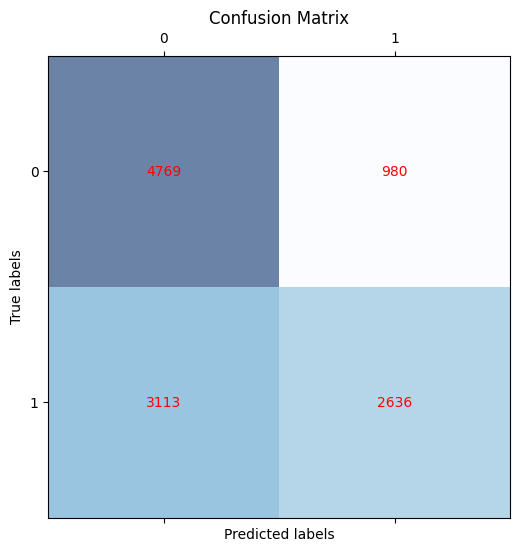

In [44]:
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer

# Aspect kelime listeleri
aspects = {
    'hız': ['fast', 'quick', 'speed', 'late', 'delayed'],
    'kalite': ['good', 'great', 'excellent', 'poor', 'bad', 'terrible', 'quality']
}

def aspect_based_sentiment_analysis_with_smote_balanced(df):
    """Aspect-based sentiment analizi SMOTE ile ve balanced_data kullanarak."""

    # Her özellik için duygu analizi yap
    def get_aspect_sentiment(text):
        words = text.split()
        aspect_scores = {aspect: 0 for aspect in aspects.keys()}
        for word in words:
            for aspect, keywords in aspects.items():
                if word in keywords:
                    aspect_scores[aspect] += 1
        return aspect_scores['hız'], aspect_scores['kalite']

    # Her bir yorum için aspect-based duygu analizi yap
    df[['Aspect_Hız', 'Aspect_Kalite']] = df['cleaned_review'].apply(get_aspect_sentiment).apply(pd.Series)

    # CountVectorizer ile kelime sıklığı (word count) çıkarımı
    vectorizer = CountVectorizer(vocabulary=sum(aspects.values(), []))
    X_aspects = vectorizer.fit_transform(df['cleaned_review']).toarray()

    # SMOTE uygulama (X: özellikler, y: etiketler)
    smote = SMOTE(k_neighbors=3)
    X_res, y_res = apply_smote(X_aspects, df['Sentiment'])

    # Model tanımlama
    model = RandomForestClassifier(random_state=42)

    # Model eğitimi
    model.fit(X_res, y_res)
    y_pred = model.predict(X_res)

    # Sonuçların değerlendirilmesi
    accuracy = accuracy_score(y_res, y_pred)
    report = classification_report(y_res, y_pred)
    cm = confusion_matrix(y_res, y_pred)

    # Sonuçların yazdırılması
    print("Aspect-Based Sentiment Analysis with SMOTE")
    print("Accuracy:", accuracy)
    print("Classification Report:\n", report)
    print("Confusion Matrix:\n", cm)

    return accuracy, report, cm

# Aspect-based fonksiyonunu çağırma
accuracy, report, cm = aspect_based_sentiment_analysis_with_smote_balanced(balanced_data)
plot_confusion_matrix(cm)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, pref

Epoch 1/5
144/144 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.7307 - loss: 0.5514 - val_accuracy: 0.9022 - val_loss: 0.2409
Epoch 2/5
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.9641 - loss: 0.1149 - val_accuracy: 0.8987 - val_loss: 0.2594
Epoch 3/5
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.9913 - loss: 0.0419 - val_accuracy: 0.8952 - val_loss: 0.3046
Epoch 4/5
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.9966 - loss: 0.0181 - val_accuracy: 0.8974 - val_loss: 0.3558
Epoch 5/5
144/144 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.9996 - loss: 0.0050 - val_accuracy: 0.8952 - val_loss: 0.3944
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
CNN with SMOTE Accuracy (Balanced Data): 0.8951965065502183
CNN with SMOTE Classification Report (Balanced Data):
               precision    recall  f1-score   support

           0       0.90      0.88      0.89      1140
           1       0.89      0.91      0.90      1150

    accuracy                           0.9

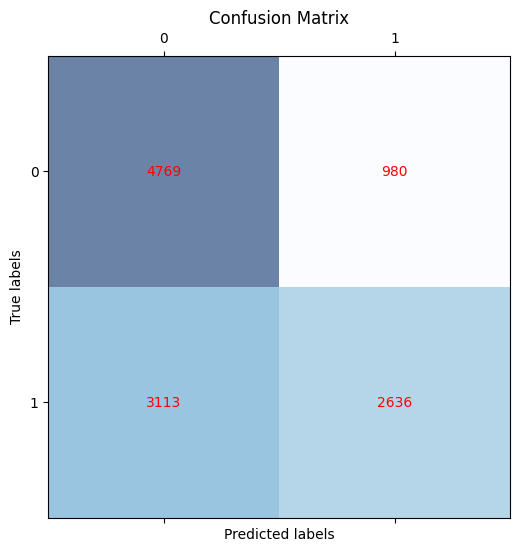

In [45]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def cnn_with_smote_sentiment_analysis_balanced(df):
    """Balanced veri seti ile CNN ve SMOTE kullanarak duygu analizi yapar ve sonuçları döner."""
    # Eğitim ve test setine ayırma
    X_train, X_test, y_train, y_test = split_data(df, 'cleaned_review', 'Sentiment')

    # TF-IDF vektörleştirme
    X_train_tfidf, X_test_tfidf, _ = vectorize_text(X_train, X_test)

    # SMOTE ile veri artırımı
    X_train_resampled, y_train_resampled = apply_smote(X_train_tfidf, y_train)

    # CNN Modelini oluştur
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train_resampled.shape[1],)),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')  # Binary sınıflandırma için sigmoid
    ])

    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    # Modeli eğit
    model.fit(
        X_train_resampled, y_train_resampled,
        epochs=5,
        batch_size=64,
        validation_data=(X_test_tfidf, y_test)
    )

    # Test seti üzerinde tahmin yap
    y_pred = model.predict(X_test_tfidf)
    y_pred = (y_pred > 0.5).astype(int).flatten()  # Sigmoid çıktıyı 0 veya 1'e dönüştür

    # Sonuçları yazdır
    print("CNN with SMOTE Accuracy (Balanced Data):", accuracy_score(y_test, y_pred))
    print("CNN with SMOTE Classification Report (Balanced Data):\n", classification_report(y_test, y_pred))
    print("CNN with SMOTE Confusion Matrix (Balanced Data):\n", confusion_matrix(y_test, y_pred))

    return accuracy, report, cm

# CNN analizi SMOTE ile balanced_data kullanılarak
accuracy, report, cm = cnn_with_smote_sentiment_analysis_balanced(balanced_data)

# Confusion Matrix'i görselleştir
plot_confusion_matrix(cm)

In [46]:
from gensim.models import Word2Vec
import numpy as np

def train_word2vec(corpus):
    """
    Word2Vec modelini eğitir ve kelimeler için vektörleri döndürür.
    """
    tokenized_corpus = [text.split() for text in corpus]  # Her yorumu tokenize et
    model = Word2Vec(sentences=tokenized_corpus, vector_size=100, window=5, min_count=1, workers=4)
    return model

def vectorize_text_with_word2vec(texts, model):
    """
    Word2Vec ile metni vektörize eder.
    """
    def average_word_vectors(words, model, vector_size):
        # Her kelimenin vektör ortalamasını al
        feature_vec = np.zeros((vector_size,), dtype='float32')
        n_words = 0
        for word in words:
            if word in model.wv:
                feature_vec = np.add(feature_vec, model.wv[word])
                n_words += 1
        if n_words > 0:
            feature_vec = np.divide(feature_vec, n_words)
        return feature_vec

    vector_size = model.vector_size
    return np.array([average_word_vectors(text.split(), model, vector_size) for text in texts])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Word2Vec Sentiment Analysis Accuracy: 0.7563318777292577
Word2Vec Sentiment Analysis Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.78      0.76      1140
           1       0.77      0.74      0.75      1150

    accuracy                           0.76      2290
   macro avg       0.76      0.76      0.76      2290
weighted avg       0.76      0.76      0.76      2290

Word2Vec Sentiment Analysis Confusion Matrix:
 [[885 255]
 [303 847]]


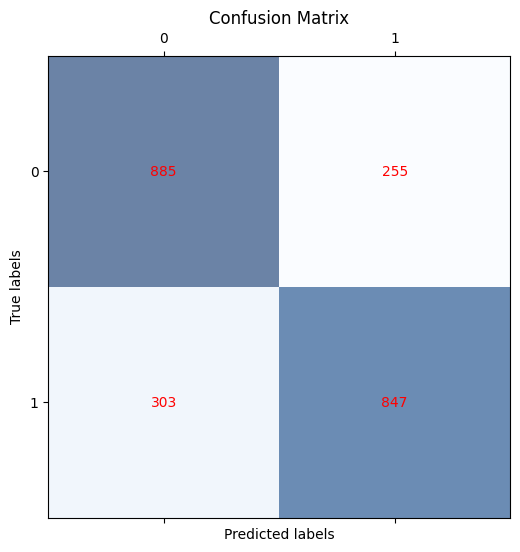

In [54]:
from sklearn.linear_model import LogisticRegression

def word2vec_sentiment_analysis(df):
    """
    Word2Vec ve bir makine öğrenimi modeli ile duygu analizi yapar.
    """
    # Eğitim ve test setine ayırma
    X_train, X_test, y_train, y_test = split_data(df, 'cleaned_review', 'Sentiment')

    # Word2Vec modelini eğit
    word2vec_model = train_word2vec(X_train)

    # Word2Vec ile veriyi vektörize et
    X_train_vec = vectorize_text_with_word2vec(X_train, word2vec_model)
    X_test_vec = vectorize_text_with_word2vec(X_test, word2vec_model)

    # SMOTE uygula
    X_train_resampled, y_train_resampled = apply_smote(X_train_vec, y_train)

    # Model oluştur ve değerlendir
    model = LogisticRegression(random_state=42)
    accuracy, report, cm = train_and_evaluate_model(model, X_train_resampled, y_train_resampled, X_test_vec, y_test)

    return accuracy, report, cm

# Word2Vec ile duygu analizi fonksiyonunu çalıştır
accuracy_word2vec, report_word2vec, cm_word2vec = word2vec_sentiment_analysis(balanced_data)

# Sonuçları yazdır
print("Word2Vec Sentiment Analysis Accuracy:", accuracy_word2vec)
print("Word2Vec Sentiment Analysis Classification Report:\n", report_word2vec)
print("Word2Vec Sentiment Analysis Confusion Matrix:\n", cm_word2vec)

# Confusion Matrix görselleştirmesi
plot_confusion_matrix(cm_word2vec)

In [ ]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import torch
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def prepare_bert_data(texts, labels, tokenizer, max_len=96):
    """BERT için veri hazırlığı: metinleri ve etiketleri tokenlara dönüştürür."""
    input_ids = []
    attention_masks = []

    for text in texts:
        encoding = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoding['input_ids'])
        attention_masks.append(encoding['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    return input_ids, attention_masks, labels

def bert_sentiment_analysis(df, batch_size=32, max_len=96, epochs=3, gradient_accumulation_steps=4):
    """DistilBERT tabanlı sentiment analizi yapar."""
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')  # Küçük model
    model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    X = df['cleaned_review'].values
    y = df['Sentiment'].values

    input_ids, attention_masks, labels = prepare_bert_data(X, y, tokenizer, max_len)

    train_size = int(0.8 * len(X))
    train_inputs, test_inputs = input_ids[:train_size], input_ids[train_size:]
    train_masks, test_masks = attention_masks[:train_size], attention_masks[train_size:]
    train_labels, test_labels = labels[:train_size], labels[train_size:]

    train_data = TensorDataset(train_inputs, train_masks, train_labels)
    test_data = TensorDataset(test_inputs, test_masks, test_labels)

    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size)

    class_weights = torch.tensor([1.0, 5.0]).to(device)  # Pozitif sınıf için ağırlık
    loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)  # Daha düşük öğrenme oranı

    for epoch in range(epochs):
        total_loss = 0
        for step, batch in enumerate(train_dataloader):
            input_ids, attention_masks, labels = [item.to(device) for item in batch]
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_masks)
            loss = loss_fn(outputs.logits, labels)
            total_loss += loss.item()
            loss.backward()

            if (step + 1) % gradient_accumulation_steps == 0:
                optimizer.step()

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_dataloader)}")

    model.eval()
    all_preds = []
    all_labels = []

    for batch in test_dataloader:
        input_ids, attention_masks, labels = [item.to(device) for item in batch]
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_masks)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    print("BERT Sentiment Accuracy:", accuracy)
    print("BERT Sentiment Classification Report:\n", report)
    print("BERT Sentiment Confusion Matrix:\n", cm)

    return accuracy, report, cm

# balanced_data DataFrame'inin önceden tanımlı olduğundan emin olun.
accuracy_bert, report_bert, cm_bert = bert_sentiment_analysis(balanced_data)
plot_confusion_matrix(cm_bert)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def content_based_recommender(df, num_recommendations=5):
    """
    İçerik tabanlı öneri sistemi, yorumlar arasındaki benzerliği kullanarak ürün önerir.
    """
    # DataFrame'in indekslerini sıfırdan başlat
    df = df.reset_index(drop=True)

    # Benzersiz bir anahtar oluştur
    df['UniqueKey'] = df.index.astype(str) + "_" + df['ProductId'].astype(str)

    # TF-IDF vektörleştirici
    vectorizer = TfidfVectorizer(stop_words='english')

    # Yorumları TF-IDF vektörlerine dönüştür
    tfidf_matrix = vectorizer.fit_transform(df['cleaned_review'])

    # Kosinüs benzerliği hesapla
    cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

    # Her ürün için en benzer ürünleri öner
    recommendations = {}

    for idx, row in df.iterrows():
        try:
            sim_scores = cosine_sim[idx]
            sorted_indices = sim_scores.argsort()[::-1][1:num_recommendations + 1]  # Kendini çıkar
            recommendations[row['UniqueKey']] = df.iloc[sorted_indices]['ProductId'].tolist()
        except Exception as e:
            print(f"Hata! İndeks: {idx}, UniqueKey: {row['UniqueKey']}, Hata: {e}")
            continue

    return recommendations

# Önerilerde bulunma
recommendations_content_based = content_based_recommender(balanced_data)
print("Content-Based Recommendations:", recommendations_content_based)

Content-Based Recommendations: {'0_B0020ZURDI': ['B0001CXUHW', 'B000SDKDM4', 'B002G96XUE', 'B001D0KG4Q', 'B0023V65GW'], '1_B0016FY6H6': ['B0012BSMJM', 'B002WDCFFG', 'B0027CNY7U', 'B0049W5NA2', 'B0050CPSBE'], '2_B000BRR8VQ': ['B000BRR8VQ', 'B002QWHJOU', 'B0018CJXHU', 'B000WFRUP6', 'B004QW4XRE'], '3_B0002DHNXC': ['B001J9URUY', 'B0002DHNXC', 'B001M19IJK', 'B000EBKS9S', 'B000EBMW9M'], '4_B00450V22G': ['B0029NIIKK', 'B000FMZO8G', 'B000LKZ3GA', 'B00014G43W', 'B0007A0AP8'], '5_B0000GHNVI': ['B000ILK9QG', 'B001D0KG3W', 'B000H1VBLY', 'B003YEYWX0', 'B003VIL6GU'], '6_B008AHJZTM': ['B001AS1A4Q', 'B004APZYVG', 'B004EE0TYK', 'B002T0NWKE', 'B002T0GXNC'], '7_B007M83302': ['B000VK8AVK', 'B001BM01BE', 'B002GJ9JWS', 'B008ZRKZSM', 'B001RVFDOO'], '8_B005CGUTIA': ['B005CGUTIA', 'B000PJMRWU', 'B002CJAOT4', 'B000F4D4HW', 'B0009ET7TC'], '9_B000RHUUU6': ['B0015Z1LY8', 'B0016BAB42', 'B000FVBYCW', 'B0007SNZQ6', 'B001EYUE4I'], '10_B005LURD2C': ['B000X1F9XY', 'B000X2CWTM', 'B000VKADSS', 'B001M050CU', 'B003TIVBSU'],

In [56]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

def collaborative_filtering(df, num_recommendations=5):
    """
    İşbirlikçi filtreleme kullanarak önerilerde bulunur.
    """
    # Sadece gerekli sütunları seç
    df = df[['UserId', 'ProductId', 'Sentiment']]

    # Duplikatları birleştir (ortalama sentiment değerini al)
    df = df.groupby(['UserId', 'ProductId'], as_index=False).mean()

    # Kullanıcı-öğe matrisini oluştur
    user_item_matrix = df.pivot(index='UserId', columns='ProductId', values='Sentiment').fillna(0)

    # Kullanıcılar arasındaki benzerliği hesapla
    cosine_sim = cosine_similarity(user_item_matrix)

    recommendations = {}

    # Doğru bir şekilde indekslemek için enumerate() kullan
    for idx, (user_id, user_data) in enumerate(user_item_matrix.iterrows()):
        # Kullanıcıya benzer diğer kullanıcıları bul
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

        # En benzer kullanıcıların önerilerini hesapla
        similar_users = [sim_user[0] for sim_user in sim_scores[1:num_recommendations + 1]]
        recommended_products = user_item_matrix.iloc[similar_users].mean(axis=0)

        # En yüksek puanı alan ürünleri öner
        recommendations[user_id] = recommended_products.sort_values(ascending=False).head(num_recommendations).index.tolist()

    return recommendations

# İşbirlikçi filtreleme ile önerilerde bulunma
recommendations_collaborative_based = collaborative_filtering(balanced_data)
print("Collaborative Filtering Recommendations:", recommendations_collaborative_based)

Collaborative Filtering Recommendations: {'#oc-R11DNU2NBKQ23Z': ['0006641040', 'B002R8UANK', 'B002VAMXXY', 'B002VAF39K', 'B002V1NWF6'], '#oc-R120LO6OLNDPCG': ['0006641040', 'B002R8UANK', 'B002VAMXXY', 'B002VAF39K', 'B002V1NWF6'], '#oc-R1522DF2LUL4G1': ['0006641040', 'B002R8UANK', 'B002VAMXXY', 'B002VAF39K', 'B002V1NWF6'], '#oc-R152UR09M996EM': ['0006641040', 'B002R8UANK', 'B002VAMXXY', 'B002VAF39K', 'B002V1NWF6'], '#oc-R1CL2JEVUKLP2C': ['0006641040', 'B002R8UANK', 'B002VAMXXY', 'B002VAF39K', 'B002V1NWF6'], '#oc-R1DRI2RP4P2TRV': ['0006641040', 'B002R8UANK', 'B002VAMXXY', 'B002VAF39K', 'B002V1NWF6'], '#oc-R1L78OM17TXMS7': ['0006641040', 'B002R8UANK', 'B002VAMXXY', 'B002VAF39K', 'B002V1NWF6'], '#oc-R1L7FHRQYER2JG': ['0006641040', 'B002R8UANK', 'B002VAMXXY', 'B002VAF39K', 'B002V1NWF6'], '#oc-R1YD35BFIT2RUP': ['0006641040', 'B002R8UANK', 'B002VAMXXY', 'B002VAF39K', 'B002V1NWF6'], '#oc-R242XV3ENMZELQ': ['0006641040', 'B002R8UANK', 'B002VAMXXY', 'B002VAF39K', 'B002V1NWF6'], '#oc-R2CQW2ZOJH2NR

In [57]:
def hybrid_recommender(content_recommendations, collaborative_recommendations, alpha=0.5):
    """
    İçerik tabanlı ve işbirlikçi filtreleme önerilerini birleştirir.
    alpha, içerik ve işbirlikçi önerilerin ağırlığını belirler.
    """
    hybrid_recommendations = {}

    for user_id in content_recommendations:
        content_based = set(content_recommendations[user_id])
        collaborative_based = set(collaborative_recommendations.get(user_id, []))

        # İki öneri setini birleştir
        combined_recommendations = content_based.union(collaborative_based)

        # Hybrid öneriyi oluştur
        hybrid_recommendations[user_id] = list(combined_recommendations)

    return hybrid_recommendations

# Hibrit öneri sistemi ile sonuçlar
hybrid_recommendations = hybrid_recommender(recommendations_content_based, recommendations_collaborative_based)
print("Hybrid Recommendations:", hybrid_recommendations)

Hybrid Recommendations: {'0_B0020ZURDI': ['B001D0KG4Q', 'B0023V65GW', 'B000SDKDM4', 'B0001CXUHW', 'B002G96XUE'], '1_B0016FY6H6': ['B002WDCFFG', 'B0027CNY7U', 'B0049W5NA2', 'B0012BSMJM', 'B0050CPSBE'], '2_B000BRR8VQ': ['B000WFRUP6', 'B004QW4XRE', 'B000BRR8VQ', 'B002QWHJOU', 'B0018CJXHU'], '3_B0002DHNXC': ['B000EBKS9S', 'B001M19IJK', 'B000EBMW9M', 'B0002DHNXC', 'B001J9URUY'], '4_B00450V22G': ['B0029NIIKK', 'B000LKZ3GA', 'B000FMZO8G', 'B00014G43W', 'B0007A0AP8'], '5_B0000GHNVI': ['B000ILK9QG', 'B000H1VBLY', 'B001D0KG3W', 'B003YEYWX0', 'B003VIL6GU'], '6_B008AHJZTM': ['B004APZYVG', 'B002T0GXNC', 'B004EE0TYK', 'B002T0NWKE', 'B001AS1A4Q'], '7_B007M83302': ['B008ZRKZSM', 'B002GJ9JWS', 'B001RVFDOO', 'B000VK8AVK', 'B001BM01BE'], '8_B005CGUTIA': ['B005CGUTIA', 'B002CJAOT4', 'B000F4D4HW', 'B000PJMRWU', 'B0009ET7TC'], '9_B000RHUUU6': ['B0015Z1LY8', 'B001EYUE4I', 'B0016BAB42', 'B000FVBYCW', 'B0007SNZQ6'], '10_B005LURD2C': ['B000VKADSS', 'B000X1F9XY', 'B000X2CWTM', 'B001M050CU', 'B003TIVBSU'], '11_B0

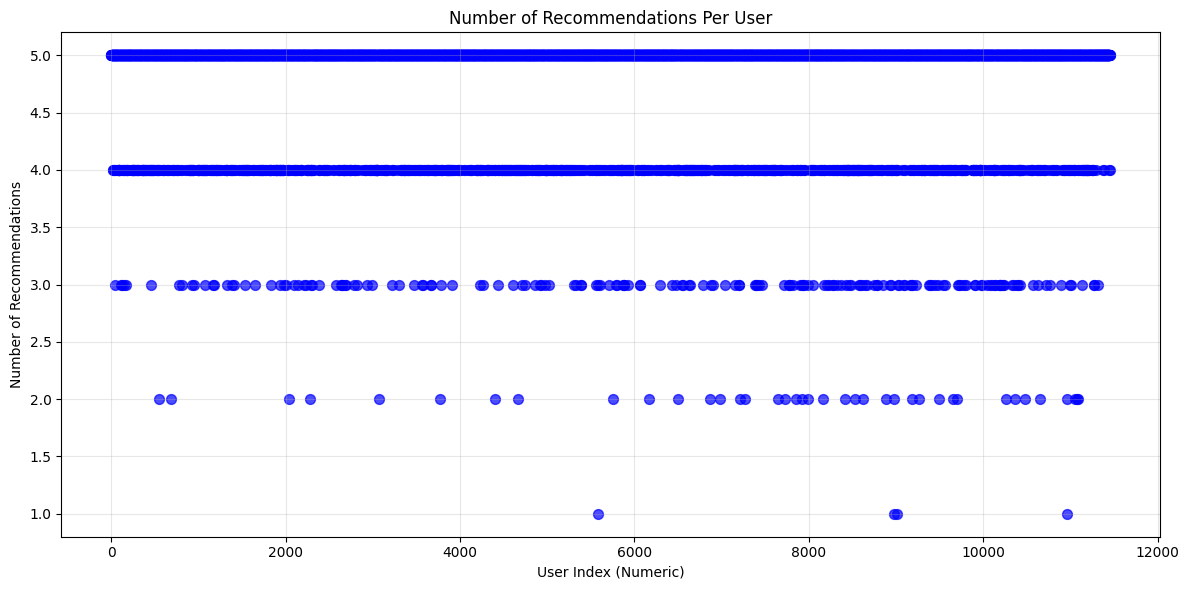

In [58]:
def visualize_recommendations_numeric_users(hybrid_recommendations):
    """
    Kullanıcı başına önerilen ürün sayısını numaralandırılmış kullanıcılar ile görselleştirir.
    """
    # Kullanıcı başına öneri sayıları
    num_recommendations = [len(recs) for recs in hybrid_recommendations.values()]
    user_indices = range(1, len(hybrid_recommendations) + 1)  # Kullanıcılar için numaralar

    # Grafik
    plt.figure(figsize=(12, 6))
    plt.scatter(user_indices, num_recommendations, color='blue', alpha=0.7, s=50)
    plt.xlabel('User Index (Numeric)')
    plt.ylabel('Number of Recommendations')
    plt.title('Number of Recommendations Per User')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Görselleştirme fonksiyonunu çağır
visualize_recommendations_numeric_users(hybrid_recommendations)

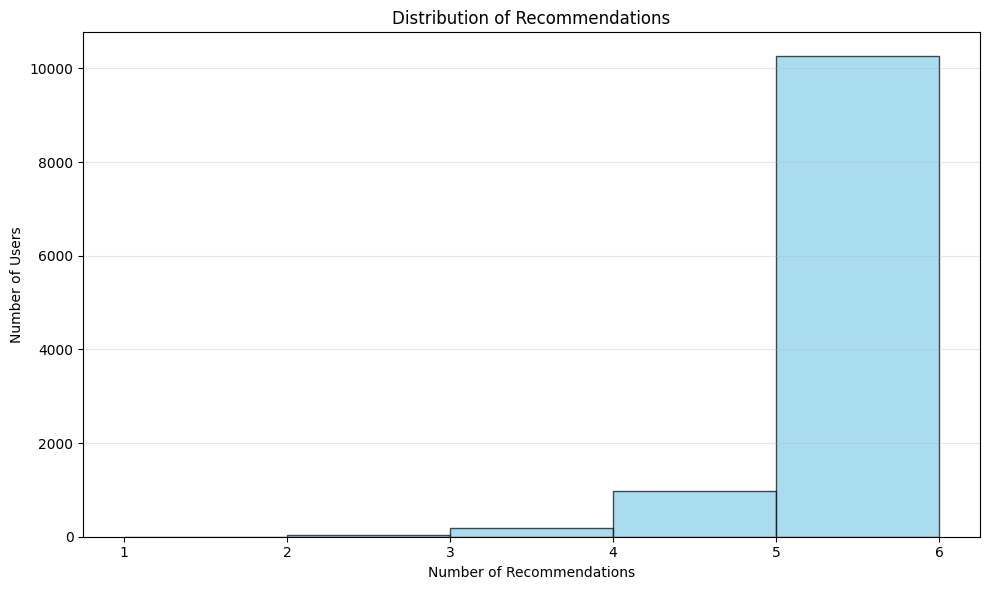

In [59]:
def visualize_recommendations_histogram(hybrid_recommendations):
    """
    Kullanıcı başına önerilen ürün sayısını histogram ile görselleştirir.
    """
    # Kullanıcı başına öneri sayıları
    num_recommendations = [len(recs) for recs in hybrid_recommendations.values()]

    # Grafik
    plt.figure(figsize=(10, 6))
    plt.hist(num_recommendations, bins=range(1, max(num_recommendations)+2), color='skyblue', edgecolor='black', alpha=0.7)
    plt.xlabel('Number of Recommendations')
    plt.ylabel('Number of Users')
    plt.title('Distribution of Recommendations')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Görselleştirme fonksiyonunu çağır
visualize_recommendations_histogram(hybrid_recommendations)

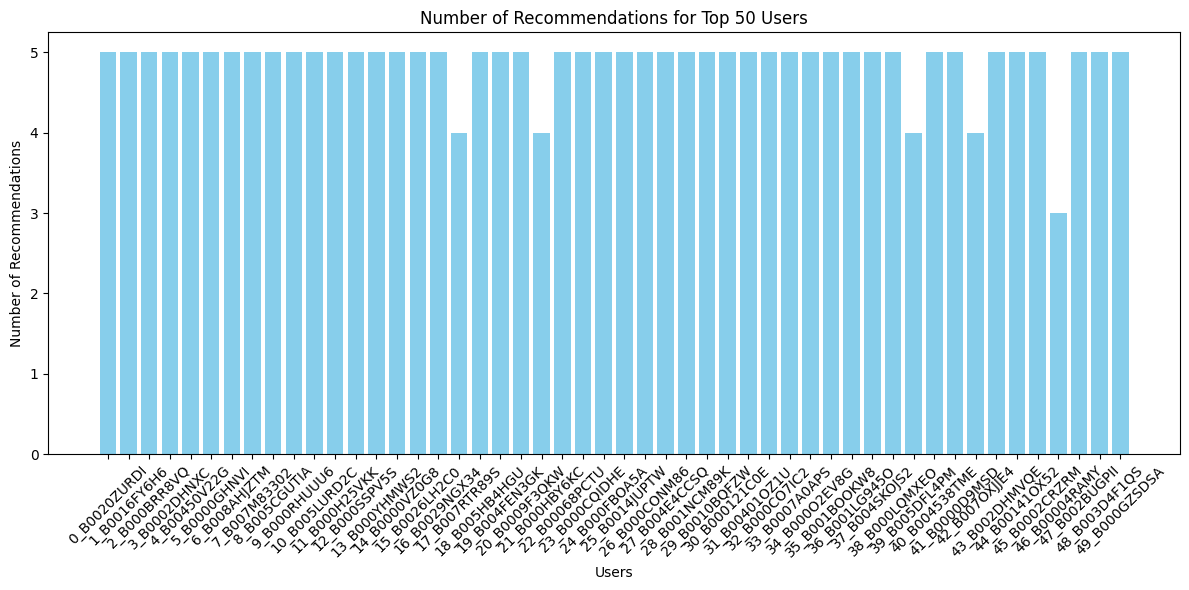

In [61]:
def visualize_recommendations_subset(hybrid_recommendations, num_users=50):
    """
    Kullanıcı başına önerilen ürün sayısını belirli sayıda kullanıcı için görselleştirir.
    """
    # İlk num_users kadar kullanıcı seç
    selected_users = list(hybrid_recommendations.keys())[:num_users]
    num_recommendations = [len(hybrid_recommendations[user]) for user in selected_users]

    plt.figure(figsize=(12, 6))
    plt.bar(selected_users, num_recommendations, color='skyblue')
    plt.xlabel('Users')
    plt.ylabel('Number of Recommendations')
    plt.title(f'Number of Recommendations for Top {num_users} Users')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Görselleştirme fonksiyonunu çağır
visualize_recommendations_subset(hybrid_recommendations, num_users=50)

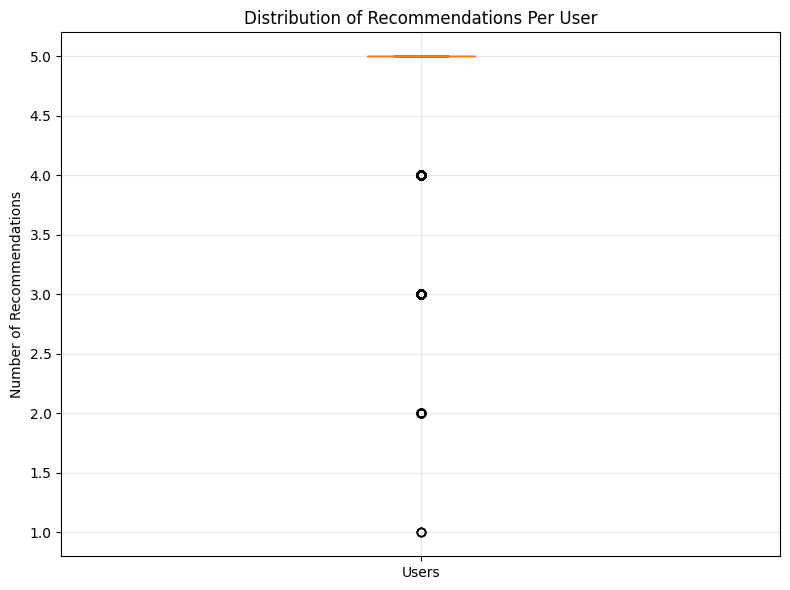

In [62]:
def visualize_recommendations_boxplot(hybrid_recommendations):
    """
    Kullanıcı başına önerilen ürün sayısını kutu grafiğiyle görselleştirir.
    """
    # Kullanıcı başına öneri sayıları
    num_recommendations = [len(recs) for recs in hybrid_recommendations.values()]

    # Grafik
    plt.figure(figsize=(8, 6))
    plt.boxplot(num_recommendations, patch_artist=True, boxprops=dict(facecolor='skyblue', color='blue'))
    plt.ylabel('Number of Recommendations')
    plt.title('Distribution of Recommendations Per User')
    plt.xticks([1], ['Users'])  # X ekseninde yalnızca "Users" etiketi
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Görselleştirme fonksiyonunu çağır
visualize_recommendations_boxplot(hybrid_recommendations)

['B001D0KG4Q', 'B0023V65GW', 'B000SDKDM4', 'B0001CXUHW', 'B002G96XUE']


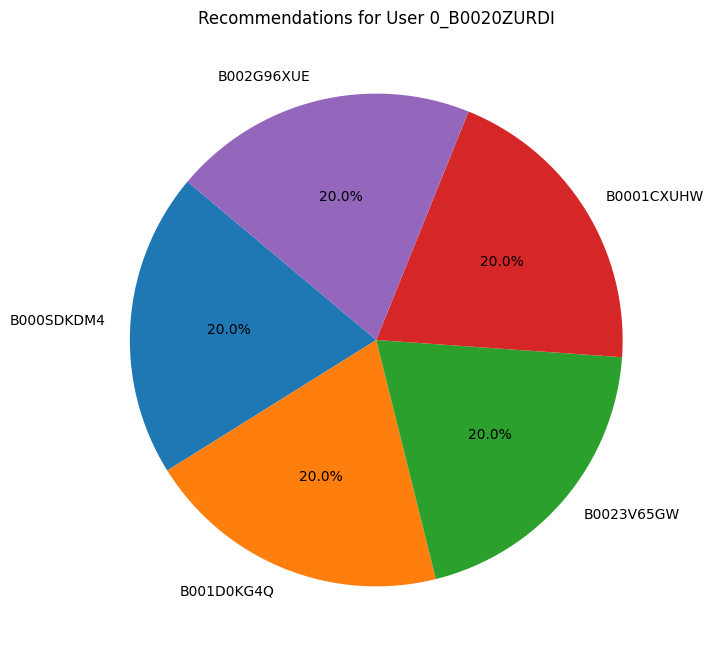

In [64]:
def visualize_user_recommendations(hybrid_recommendations, user_id):
    print(hybrid_recommendations.get(user_id, []))
    """
    Belirli bir kullanıcı için önerilen ürünleri pasta grafiği ile görselleştirir.
    """
    user_recommendations = hybrid_recommendations.get(user_id, [])
    product_counts = {product: user_recommendations.count(product) for product in set(user_recommendations)}

    # Grafik
    plt.figure(figsize=(8, 8))
    plt.pie(product_counts.values(), labels=product_counts.keys(), autopct='%1.1f%%', startangle=140, colors=plt.cm.tab10.colors)
    plt.title(f'Recommendations for User {user_id}')
    plt.show()

# Örnek: Belirli bir kullanıcıyı görselleştir
visualize_user_recommendations(hybrid_recommendations, user_id="0_B0020ZURDI")

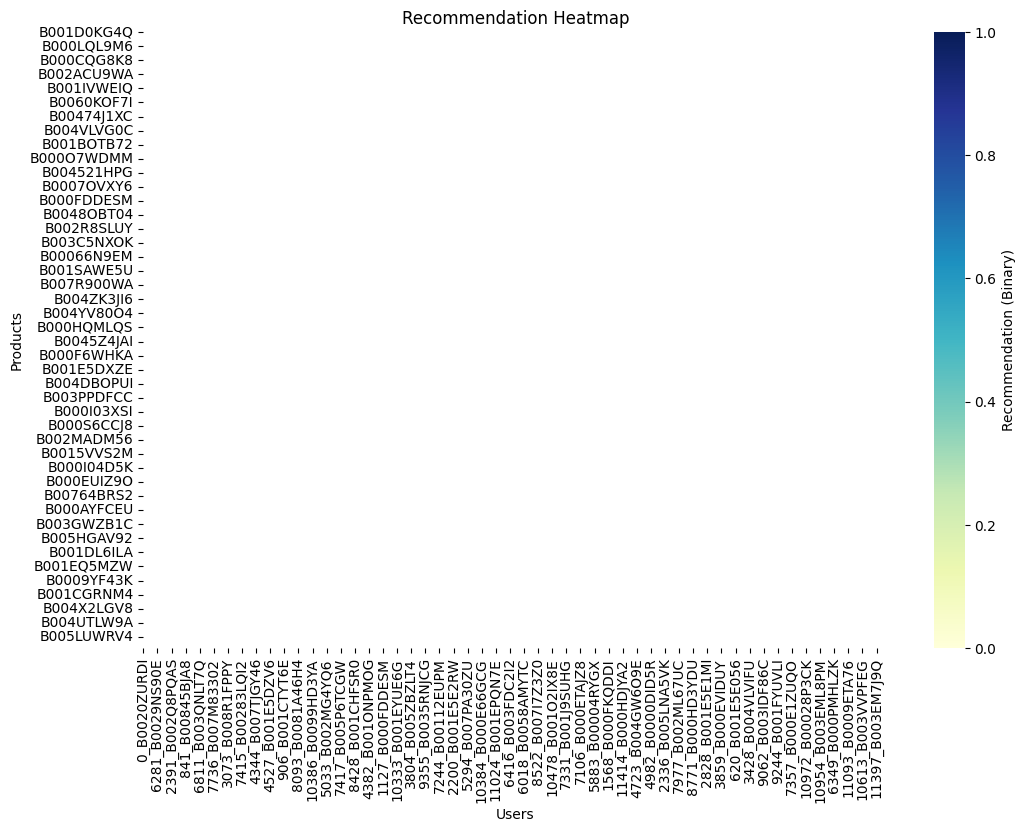

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def visualize_recommendation_heatmap(hybrid_recommendations):
    """
    Önerileri ısı haritası şeklinde görselleştirir.
    """
    # Kullanıcı-ürün matrisini oluştur
    user_product_matrix = {}
    for user, products in hybrid_recommendations.items():
        user_product_matrix[user] = {product: 1 for product in products}  # Her ürün için 1 değerini atar

    # DataFrame'e çevir
    recommendation_matrix = pd.DataFrame.from_dict(user_product_matrix, orient='index').fillna(0)

    # Isı haritası çiz
    plt.figure(figsize=(12, 8))
    sns.heatmap(recommendation_matrix.T, cmap="YlGnBu", cbar_kws={'label': 'Recommendation (Binary)'}, linewidths=0.5)
    plt.title('Recommendation Heatmap')
    plt.xlabel('Users')
    plt.ylabel('Products')
    plt.show()

# Görselleştirme
visualize_recommendation_heatmap(hybrid_recommendations)